# Optimization Practical

In this tutorial, we learn how to create an optimization model from scratch, and solve it.

## 0) Seting up the Environment and Solver

### Python environment

First we need to prepare our python environment. Rund the following code for installing the required libraries. Skip if you already installed it before.

In [1]:
%pip install gurobipy matplotlib numpy pandas

import sys
print(sys.version)

try:
    import gurobipy as gp
    from gurobipy import GRB
    print("✅ gurobipy version:", gp.gurobi.version())
except Exception as e:
    print("❌ gurobipy import failed:", e)




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
3.12.1 (main, Jul 10 2025, 11:57:50) [GCC 13.3.0]
✅ gurobipy version: (13, 0, 0)


You now must have GurobiPy installed and imported.  Run the following cell make sure you already have the Gurobi environment stared.

In [2]:
from gurobipy import GRB
print("License status (short):")
try:
    env = gp.Env(empty=True)
    env.start()
    print("✅ Gurobi environment started")
except Exception as e:
    print("⚠️ Could not start environment:", e)

License status (short):
Restricted license - for non-production use only - expires 2027-11-29
✅ Gurobi environment started


If you get the massage "Could not start environment", there migh be a problem with your liesence. Got to Gurobi.com, create an account, follow their instructions, and install their free academic liesence. I'm sure ChatGPT can help in this section :))

In case gurobypy is still not working, you can use HiGHS which is an open source LP/MILP solver. Ignore the following cell if everything is Okay!

In [3]:
%pip install -q highspy


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gb

Let's solve the Factory problem from the previous lecture. Let's start with the continuous relaxation of the problem, meaning that we do not require the decision variables be integers. The mathematical formulation of the problem is:

$$
\begin{aligned}
\max\; & 150x + 175y \\
\text{s.t. } 
& 7x + 11y \le 77 \\
& 10x + 8y \le 80 \\
& x \le 8 \\ 
& x, y \ge 0
\end{aligned}
$$

The mathematical formulation includes material, time, and capacity constriants. 

Run the following block of code to get the nice plot of our problem.

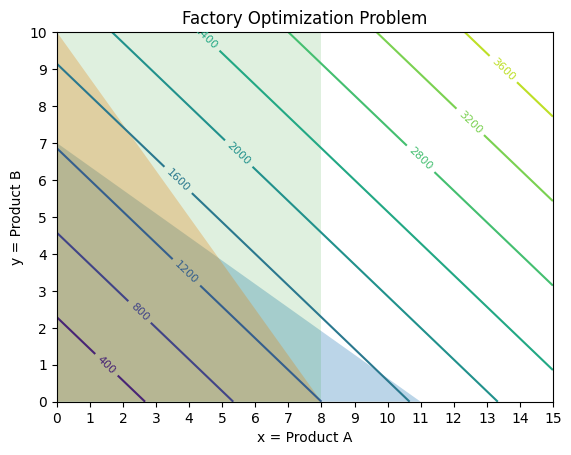

In [9]:
pa = 150
pb = 175

a = np.arange(0, 15.0 + 0.5, 0.5)  # 0:0.5:15
b = np.arange(0, 10.0 + 0.5, 0.5)  # 0:0.5:10

def f(a, b):
    return pa * a + pb * b

A, B = np.meshgrid(a, b)
Z = f(A, B)

plt.figure()

contours = plt.contour(A, B, Z, levels=10)
plt.clabel(contours, inline=True, fontsize=8)

# Titles and axis labels
plt.title("Factory Optimization Problem")
plt.xlabel("x = Product A")
plt.ylabel("y = Product B")

# Ticks
plt.xticks(np.arange(0, a.max() + 1, 1))
plt.yticks(np.arange(0, b.max() + 1, 1))

# --- Constraint regions (area plots) ---

# 1) 7a + 11b <= 77  ->  b <= (77 - 7a)/11, for a <= 11
a1 = a[a <= 11]
b1 = (77 - 7 * a1) / 11
b1 = np.maximum(b1, 0)  # avoid negative values
plt.fill_between(a1, 0, b1, alpha=0.3)

# 2) 10a + 8b <= 80  ->  b <= (80 - 10a)/8, for a <= 8
a2 = a[a <= 8]
b2 = (80 - 10 * a2) / 8
b2 = np.maximum(b2, 0)
plt.fill_between(a2, 0, b2, alpha=0.3)

# 3) a <= 8, 0 <= b <= max(b)  (vertical strip up to b_max)
a3 = a[a <= 8]
b_max = b.max()
plt.fill_between(a3, 0, b_max, alpha=0.15)

plt.xlim(0, a.max())
plt.ylim(0, b.max())

plt.show()

OKay. Let's create our Optimization model. 

### 1. Define the model and choose a solver

In python we use a model object to represent our optimization problem. We use **Gurobi** as the solver via its python interface 'gurobypy'.

The model is initially empty as we have not defined any variables, constraints, or objective. We create the model with gurobipy, which automatically selects Gurobi as our solver.

In [35]:
# create an empty model

model = gp.Model("Factory_Optimization")

print("Empty model created.")
print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)


Empty model created.
Number of variables: 0
Number of constraints: 0


### 2. Define Variables

Next, we define our variables by 'addVar'. Remember, x and y are our continuous non-negative decision variables, representing the number of production for products A and B. 

In [36]:

x = model.addVar(name="x", vtype=GRB.CONTINUOUS, lb=0, ub=8)  # Product A

y = model.addVar(name="y", vtype=GRB.CONTINUOUS, lb=0)  # Product B

model.update() # we update the model just to show the variables have been added. Later when you write your own code, you can skip this line.

print("Number of variables:", model.NumVars)
print("Number of constraints:", model.NumConstrs)

Number of variables: 2
Number of constraints: 0


Note that, we already satisfy the non-negativity and capacity constraints by setting the lb=0 and ub=8 for variable x and y. 


### 3. Define the objective 

Now, let's define the objective. In every optimization model, we also have some information given, in the form of paramters. We can define these parameters ourselves, or load them into our software from a CSV file if the size of the input data is large. The cost of the production for each product is a paramter which we define here.

In [ ]:
pa = 150
pb = 175

model.setObjective(pa *x + pb *y, GRB.MAXIMIZE) # by GRB.MAXIMIZE we set the objective function to maximize profit